In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('filtered4_df.csv')

In [11]:
df.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Season', 'Game_ID', 'PLAYER_NAME',
       'POS', 'Team', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'VIDEO_AVAILABLE', 'DD', 'TD',
       'total_fantasy_points'], dtype=object)

In [12]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# model 1

In [14]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# parameters
hidden_size = 128
num_layers = 3
output_size = 1
dropout_prob = 0.5

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.L1Loss()  # Change to Mean Absolute Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# training loop
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# store values
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # Update the learning rate
        scheduler.step(test_loss)
    
    # Append the loss and accuracy values to the corresponding lists
    train_losses.append(avg_epoch_loss)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)
    
    # train
    model.train()


Epoch [1/100], Average Loss: 7.7902
Epoch [1/100], Average Test Loss: 7.0401, Test Accuracy: 0.5301
Epoch [2/100], Average Loss: 7.2035
Epoch [2/100], Average Test Loss: 7.0436, Test Accuracy: 0.5350
Epoch [3/100], Average Loss: 7.0902
Epoch [3/100], Average Test Loss: 5.4018, Test Accuracy: 0.6575
Epoch [4/100], Average Loss: 5.2935
Epoch [4/100], Average Test Loss: 4.4519, Test Accuracy: 0.7304
Epoch [5/100], Average Loss: 4.9115
Epoch [5/100], Average Test Loss: 4.2063, Test Accuracy: 0.7495
Epoch [6/100], Average Loss: 4.9699
Epoch [6/100], Average Test Loss: 4.0851, Test Accuracy: 0.7544
Epoch [7/100], Average Loss: 4.7067
Epoch [7/100], Average Test Loss: 4.1839, Test Accuracy: 0.7721
Epoch [8/100], Average Loss: 4.6743
Epoch [8/100], Average Test Loss: 4.0807, Test Accuracy: 0.7629
Epoch [9/100], Average Loss: 4.6538
Epoch [9/100], Average Test Loss: 4.0183, Test Accuracy: 0.7679
Epoch [10/100], Average Loss: 4.4866
Epoch [10/100], Average Test Loss: 3.7870, Test Accuracy: 0.778

Epoch [77/100], Average Loss: 3.3635
Epoch [77/100], Average Test Loss: 3.4152, Test Accuracy: 0.7870
Epoch [78/100], Average Loss: 3.3605
Epoch [78/100], Average Test Loss: 3.4156, Test Accuracy: 0.7877
Epoch [79/100], Average Loss: 3.3486
Epoch [79/100], Average Test Loss: 3.4166, Test Accuracy: 0.7877
Epoch [80/100], Average Loss: 3.3618
Epoch [80/100], Average Test Loss: 3.4164, Test Accuracy: 0.7877
Epoch [81/100], Average Loss: 3.3693
Epoch [81/100], Average Test Loss: 3.4168, Test Accuracy: 0.7877
Epoch [82/100], Average Loss: 3.3620
Epoch [82/100], Average Test Loss: 3.4156, Test Accuracy: 0.7877
Epoch 00082: reducing learning rate of group 0 to 1.9531e-06.
Epoch [83/100], Average Loss: 3.3795
Epoch [83/100], Average Test Loss: 3.4181, Test Accuracy: 0.7870
Epoch [84/100], Average Loss: 3.3261
Epoch [84/100], Average Test Loss: 3.4199, Test Accuracy: 0.7863
Epoch [85/100], Average Loss: 3.3917
Epoch [85/100], Average Test Loss: 3.4174, Test Accuracy: 0.7863
Epoch [86/100], Aver

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 3.4170
R^2 Score: 0.6321


In [19]:
import matplotlib.pyplot as plt

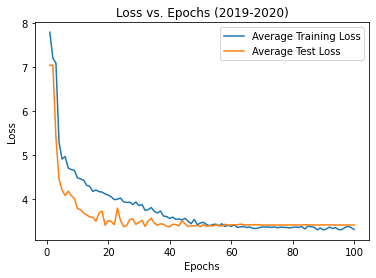

In [20]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Average Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (2019-2020)')
plt.legend()
plt.show()

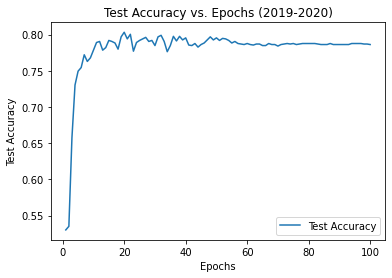

In [21]:
# Plot testing accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs (2019-2020)')
plt.legend()
plt.show()

# model 2

In [ ]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# LSTM model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# parameters
hidden_size = 64
num_layers = 2
output_size = 1

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [9]:
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
    # train
    model.train()


Epoch [1/100], Average Loss: 280.5465
Epoch [1/100], Average Test Loss: 157.4014, Test Accuracy: 0.4556
Epoch [2/100], Average Loss: 129.8602
Epoch [2/100], Average Test Loss: 129.5764, Test Accuracy: 0.4556
Epoch [3/100], Average Loss: 122.3947
Epoch [3/100], Average Test Loss: 128.8477, Test Accuracy: 0.4458
Epoch [4/100], Average Loss: 122.3301
Epoch [4/100], Average Test Loss: 128.7806, Test Accuracy: 0.4458
Epoch [5/100], Average Loss: 102.4673
Epoch [5/100], Average Test Loss: 77.0845, Test Accuracy: 0.6844
Epoch [6/100], Average Loss: 64.2551
Epoch [6/100], Average Test Loss: 59.9792, Test Accuracy: 0.7140
Epoch [7/100], Average Loss: 52.9698
Epoch [7/100], Average Test Loss: 53.8908, Test Accuracy: 0.7278
Epoch [8/100], Average Loss: 46.3377
Epoch [8/100], Average Test Loss: 49.3219, Test Accuracy: 0.7535
Epoch [9/100], Average Loss: 42.6789
Epoch [9/100], Average Test Loss: 46.9387, Test Accuracy: 0.7594
Epoch [10/100], Average Loss: 39.0522
Epoch [10/100], Average Test Loss: 

Epoch [81/100], Average Loss: 1.6583
Epoch [81/100], Average Test Loss: 50.5410, Test Accuracy: 0.7456
Epoch [82/100], Average Loss: 1.7533
Epoch [82/100], Average Test Loss: 49.1530, Test Accuracy: 0.7495
Epoch [83/100], Average Loss: 2.2276
Epoch [83/100], Average Test Loss: 52.2982, Test Accuracy: 0.7061
Epoch [84/100], Average Loss: 1.8846
Epoch [84/100], Average Test Loss: 48.1783, Test Accuracy: 0.7495
Epoch [85/100], Average Loss: 1.5289
Epoch [85/100], Average Test Loss: 50.6996, Test Accuracy: 0.7258
Epoch [86/100], Average Loss: 1.3653
Epoch [86/100], Average Test Loss: 50.7758, Test Accuracy: 0.7318
Epoch [87/100], Average Loss: 1.2027
Epoch [87/100], Average Test Loss: 50.3698, Test Accuracy: 0.7298
Epoch [88/100], Average Loss: 1.1608
Epoch [88/100], Average Test Loss: 50.3150, Test Accuracy: 0.7199
Epoch [89/100], Average Loss: 1.1875
Epoch [89/100], Average Test Loss: 48.9649, Test Accuracy: 0.7337
Epoch [90/100], Average Loss: 1.2829
Epoch [90/100], Average Test Loss: 4

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 4.5834
R^2 Score: 0.6585


## Now that we have trained the LSTM model, let us construct a function that predicts the total fantasy points that each player will generate for their next future game. 

In [23]:
sequence_length = 50

player_names_50 = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:
        player_names_50.append(player_name)

player_names_50 

['Aaron Gordon',
 'Aaron Holiday',
 'Al Horford',
 'Alec Burks',
 'Alex Caruso',
 'Alex Len',
 'Andre Drummond',
 'Andrew Wiggins',
 'Anfernee Simons',
 'Anthony Davis',
 'Austin Rivers',
 'Bam Adebayo',
 'Ben Simmons',
 'Bismack Biyombo',
 'Bobby Portis',
 'Bradley Beal',
 'Brandon Clarke',
 'Brandon Ingram',
 'Brook Lopez',
 'Bruce Brown',
 'Bruno Fernando',
 'Bryn Forbes',
 'Buddy Hield',
 'CJ McCollum',
 'Cam Reddish',
 'Cameron Johnson',
 'Cedi Osman',
 'Chris Boucher',
 'Chris Paul',
 'Christian Wood',
 'Coby White',
 'Cody Zeller',
 'Collin Sexton',
 'Cory Joseph',
 "D'Angelo Russell",
 'Damian Jones',
 'Damian Lillard',
 'Daniel Theis',
 'Danny Green',
 'Danuel House Jr.',
 'Darius Bazley',
 'Darius Garland',
 "De'Aaron Fox",
 "De'Andre Hunter",
 "De'Anthony Melton",
 'DeAndre Jordan',
 'DeMar DeRozan',
 'Dejounte Murray',
 'Delon Wright',
 'Derrick Jones Jr.',
 'Derrick Rose',
 'Derrick White',
 'Devin Booker',
 "Devonte' Graham",
 'Dewayne Dedmon',
 'Dillon Brooks',
 'Domanta

In [24]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,62
1,Aaron Holiday,66
2,Admiral Schofield,33
3,Al Horford,67
4,Alec Burks,66
...,...,...
283,Isaiah Roby,3
284,Juan Toscano-Anderson,39
285,Reggie Bullock,29
286,Victor Oladipo,19


In [25]:
filtered_df = seq_lengths_df[seq_lengths_df['SEQ_LENGTH'] >= 50]
print(filtered_df)

         PLAYER_NAME  SEQ_LENGTH
0       Aaron Gordon          62
1      Aaron Holiday          66
3         Al Horford          67
4         Alec Burks          66
5        Alex Caruso          64
..               ...         ...
269      Tyler Herro          55
270       Tyus Jones          65
274  Wesley Matthews          67
275      Will Barton         174
278      Zach LaVine          60

[204 rows x 2 columns]


In [26]:
player_name = 'Aaron Gordon'
player_points_sequence = df.loc[df['PLAYER_NAME'] == player_name, 'total_fantasy_points'].tolist()
player_points_sequence

[13.0,
 37.75,
 20.5,
 19.0,
 39.75,
 35.25,
 30.25,
 25.25,
 16.25,
 17.0,
 27.5,
 36.0,
 29.75,
 22.75,
 29.25,
 30.25,
 20.25,
 26.0,
 8.0,
 24.25,
 26.0,
 17.5,
 29.75,
 22.75,
 23.5,
 31.25,
 21.75,
 25.25,
 19.5,
 42.25,
 39.0,
 40.5,
 44.0,
 45.75,
 23.5,
 34.0,
 32.5,
 38.5,
 32.75,
 22.75,
 23.75,
 28.25,
 33.75,
 29.5,
 26.0,
 15.0,
 28.0,
 27.0,
 17.75,
 22.0,
 26.0,
 29.25,
 22.25,
 29.5,
 33.75,
 27.25,
 26.5,
 34.0,
 29.5,
 27.25,
 37.5,
 21.75]

## example of one player's predicted total fantasy points for their next game

In [27]:
# MODEL 1
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 5.12


In [14]:
# MODEL 2
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 5.08


# sequence length for all games

In [28]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

In [29]:
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,62
1,Aaron Holiday,66
2,Admiral Schofield,33
3,Al Horford,67
4,Alec Burks,66
...,...,...
283,Isaiah Roby,3
284,Juan Toscano-Anderson,39
285,Reggie Bullock,29
286,Victor Oladipo,19


# sequence length with cutoff date

In [30]:
seq_lengths = []
cutoff_date = '2021-01-16'  # Specify the cutoff date as a string in the format 'YYYY-MM-DD'

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
seq_lengths_cut_df = pd.DataFrame(seq_lengths)
seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)


In [31]:
seq_lengths_cut_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,62
1,Aaron Holiday,66
2,Admiral Schofield,33
3,Al Horford,67
4,Alec Burks,66
...,...,...
283,Isaiah Roby,3
284,Juan Toscano-Anderson,39
285,Reggie Bullock,29
286,Victor Oladipo,19


## function that predicts all players total fantasy points for their next game

In [32]:
# FOR MODEL 1
def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df_1 = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df_1)


               PLAYER_NAME  PRED_SCORE
0             Aaron Gordon    5.401420
1            Aaron Holiday    5.834579
2        Admiral Schofield    4.781713
3               Al Horford    8.019157
4               Alec Burks    5.828074
..                     ...         ...
283            Isaiah Roby    2.535780
284  Juan Toscano-Anderson    6.991392
285         Reggie Bullock    4.825073
286         Victor Oladipo    5.359767
287        Zion Williamson    5.852067

[288 rows x 2 columns]


In [42]:
# FOR MODEL 2

def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df)


               PLAYER_NAME  PRED_SCORE
0             Aaron Gordon    6.514287
1            Aaron Holiday    6.428636
2        Admiral Schofield    5.701631
3               Al Horford    8.614303
4               Alec Burks    6.560382
..                     ...         ...
283            Isaiah Roby    2.869472
284  Juan Toscano-Anderson    5.978497
285         Reggie Bullock    4.581472
286         Victor Oladipo    5.927368
287        Zion Williamson    5.510965

[288 rows x 2 columns]


In [117]:
num_unique_names = len(df['PLAYER_NAME'].unique())
print(num_unique_names)


260


# with cutoff

In [33]:
def get_seq_lengths_cut(df, cutoff_date):
    seq_lengths = []
    for player_name in df['PLAYER_NAME'].unique():
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
        seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
    seq_lengths_cut_df = pd.DataFrame(seq_lengths)
    seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
    seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)
    return seq_lengths_cut_df


In [34]:
# MODEL 1
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df_1 = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df_1 = predictions_df_1.dropna()
    return predictions_df_1


In [35]:
cutoff_date = '2020-08-14'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_1 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_1)

               PLAYER_NAME  PRED_SCORE
0             Aaron Gordon    6.102532
1            Aaron Holiday    4.882005
2        Admiral Schofield    4.128066
3               Al Horford    9.721408
4               Alec Burks    6.435576
..                     ...         ...
283            Isaiah Roby    3.498695
284  Juan Toscano-Anderson    6.316225
285         Reggie Bullock    5.076793
286         Victor Oladipo    7.889336
287        Zion Williamson    5.414298

[288 rows x 2 columns]


In [24]:
cutoff_date = '2023-04-07'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

        PLAYER_NAME  PRED_SCORE
0        A.J. Green    4.688403
1       A.J. Lawson    4.444252
2        AJ Griffin    6.383202
3      Aaron Gordon    4.791063
4     Aaron Holiday    6.183745
..              ...         ...
497     Skylar Mays    7.279849
498   Stanley Umude    4.753389
499  Sterling Brown    4.929890
500     Xavier Moon    5.178722
501    Xavier Sneed    5.500510

[502 rows x 2 columns]


In [36]:
merged_df = pd.merge(predictions_df_1, player_predictions_df_1, on='PLAYER_NAME', how='left', suffixes=('_cutoff', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE_cutoff,PRED_SCORE_all
0,Aaron Gordon,6.102532,5.401420
1,Aaron Holiday,4.882005,5.834579
2,Admiral Schofield,4.128066,4.781713
3,Al Horford,9.721408,8.019157
4,Alec Burks,6.435576,5.828074
...,...,...,...
283,Isaiah Roby,3.498695,2.535780
284,Juan Toscano-Anderson,6.316225,6.991392
285,Reggie Bullock,5.076793,4.825073
286,Victor Oladipo,7.889336,5.359767


In [70]:
# MODEL 2
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


In [131]:
cutoff_date = '2021-01-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [134]:
cutoff_date = '2021-05-01'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   32.334389
1            Alec Burks   14.217628
2    Aleksej Pokusevski   18.038410
3              Alex Len   18.154522
4           Amir Coffey   17.964472
..                  ...         ...
254        Torrey Craig   20.476349
255       Trent Forrest    8.772673
256      Troy Brown Jr.   10.206540
257           Ty Jerome   23.073565
259         Will Barton   20.324869

[256 rows x 2 columns]


# save predictions

In [44]:
filtered4_prediction = player_predictions_df
print(filtered4_prediction)
filtered4_prediction.to_csv('filtered4_prediction.csv')

               PLAYER_NAME  PRED_SCORE
0             Aaron Gordon    6.514287
1            Aaron Holiday    6.428636
2        Admiral Schofield    5.701631
3               Al Horford    8.614303
4               Alec Burks    6.560382
..                     ...         ...
283            Isaiah Roby    2.869472
284  Juan Toscano-Anderson    5.978497
285         Reggie Bullock    4.581472
286         Victor Oladipo    5.927368
287        Zion Williamson    5.510965

[288 rows x 2 columns]


In [45]:
# cutoff 8/14/2020
filtered1_prediction_cutoff_2 = predictions_df_1
print(filtered1_prediction_cutoff_2)
filtered1_prediction_cutoff_2.to_csv('filtered4_prediction_cutoff_8_14.csv')

               PLAYER_NAME  PRED_SCORE
0             Aaron Gordon    6.102532
1            Aaron Holiday    4.882005
2        Admiral Schofield    4.128066
3               Al Horford    9.721408
4               Alec Burks    6.435576
..                     ...         ...
283            Isaiah Roby    3.498695
284  Juan Toscano-Anderson    6.316225
285         Reggie Bullock    5.076793
286         Victor Oladipo    7.889336
287        Zion Williamson    5.414298

[288 rows x 2 columns]


In [136]:
# cutoff 1/16
filtered3_prediction_cutoff_1_16 = predictions_df_1
print(filtered3_prediction_cutoff_1_16)
filtered3_prediction_cutoff_1_16.to_csv('filtered3_prediction_cutoff_1_16.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [79]:
merged_df = pd.merge(predictions_df_2, player_predictions_df, on='PLAYER_NAME', how='left', suffixes=('_cutoff', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE_cutoff,PRED_SCORE_all
0,Aaron Gordon,6.828502,6.828502
1,Alec Burks,3.688114,3.671882
2,Aleksej Pokusevski,7.920433,7.157177
3,Alex Len,5.090460,5.077754
4,Amir Coffey,6.854105,6.854105
...,...,...,...
251,Torrey Craig,7.089234,5.211455
252,Trent Forrest,3.776723,3.814262
253,Troy Brown Jr.,4.665051,4.665051
254,Ty Jerome,8.067554,8.067554
